In [1]:
from numpy.random import seed
seed(101)


import pandas as pd
import numpy as np


import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

base_dir = 'base_dir'
os.mkdir(base_dir)



train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)




nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)


In [3]:
df_data = pd.read_csv('C:/Users/Annu/Desktop/Sem 4/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df = df_data.groupby('lesion_id').count()


df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [5]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

df_data['duplicates'] = df_data['lesion_id']

df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [6]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [7]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [8]:
y = df['dx']

_, df_val = train_test_split(df, test_size=0.20, random_state=101, stratify=y)

df_val.shape

(1103, 8)

In [9]:
df_val['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

In [10]:

def identify_val_rows(x):

    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'



df_data['train_or_val'] = df_data['image_id']

df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

8912
1103


In [11]:
df_train['dx'].value_counts()

nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [12]:
df_val['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

In [13]:
df_data.set_index('image_id', inplace=True)

In [15]:
folder_1 = os.listdir('C:/Users/Annu/Desktop/Sem 4/ham10000_images_part_1')
folder_2 = os.listdir('C:/Users/Annu/Desktop/Sem 4/ham10000_images_part_2')


train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])




for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        
        src = os.path.join('C:/Users/Annu/Desktop/Sem 4/ham10000_images_part_1', fname)
        
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        
        src = os.path.join('C:/Users/Annu/Desktop/Sem 4/ham10000_images_part_2', fname)
        
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)




for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        
        src = os.path.join('C:/Users/Annu/Desktop/Sem 4/ham10000_images_part_1', fname)
        
        dst = os.path.join(val_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        
        src = os.path.join('C:/Users/Annu/Desktop/Sem 4/ham10000_images_part_2', fname)
        
        dst = os.path.join(val_dir, label, fname)
        
        shutil.copyfile(src, dst)
        


In [16]:


print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5822
1067
1011
479
297
129
107


In [17]:


print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

883
46
88
35
30
13
8


In [18]:

class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    
    img_class = item

    
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    
    for fname in img_list:
            
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            
            dst = os.path.join(img_dir, fname)
            
            shutil.copyfile(src, dst)


    
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class


    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    
    
    num_aug_images_wanted = 6000 
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    
    shutil.rmtree('aug_dir')

Found 1067 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 297 images belonging to 1 classes.
Found 129 images belonging to 1 classes.
Found 107 images belonging to 1 classes.


In [19]:


print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5822
5885
5855
5798
5990
5210
4330


In [20]:

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

883
46
88
35
30
13
8


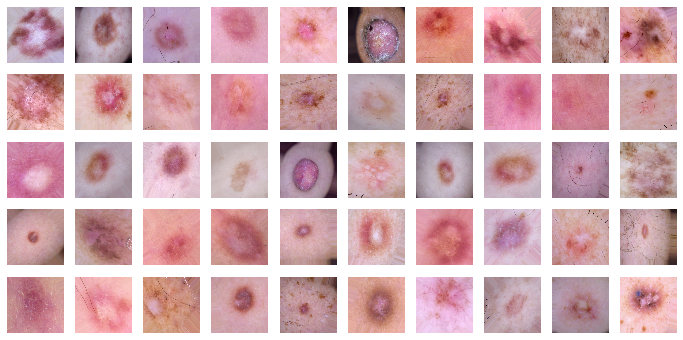

In [21]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) 

In [22]:
df_train

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates,train
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,has_duplicates,train
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,has_duplicates,train
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,has_duplicates,train
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,has_duplicates,train


In [23]:
df_val

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
6393,HAM_0005002,ISIC_0031869,nv,follow_up,35.0,male,back,no_duplicates
5047,HAM_0004292,ISIC_0029625,nv,follow_up,65.0,male,trunk,no_duplicates
4554,HAM_0000244,ISIC_0029057,nv,follow_up,45.0,male,back,no_duplicates
409,HAM_0002769,ISIC_0032481,bkl,histo,80.0,male,back,no_duplicates
6845,HAM_0001542,ISIC_0026874,nv,histo,80.0,male,lower extremity,no_duplicates
...,...,...,...,...,...,...,...,...
5241,HAM_0002072,ISIC_0027794,nv,follow_up,50.0,male,back,no_duplicates
4754,HAM_0005959,ISIC_0025058,nv,follow_up,25.0,male,back,no_duplicates
4592,HAM_0002188,ISIC_0032196,nv,follow_up,45.0,male,trunk,no_duplicates
5944,HAM_0007006,ISIC_0025497,nv,follow_up,50.0,female,upper extremity,no_duplicates


In [24]:
print(len(df_train),len(df_val))

8912 1103


In [25]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 150

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [26]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)


test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38890 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [27]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

In [28]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [29]:
for layer in base_model.layers:
    layer.trainable = False

In [30]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [31]:
inc_history = model.fit_generator(train_batches, validation_data = valid_batches, steps_per_epoch = 100, epochs = 100)

C:\Users\Annu\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 102s 939ms/step - loss: 5.4670 - acc: 0.2520 - val_loss: 1.7569 - val_acc: 0.5476
Epoch 2/100
100/100 [==============================] - 67s 670ms/step - loss: 2.3078 - acc: 0.3995 - val_loss: 0.8290 - val_acc: 0.7770
Epoch 3/100
100/100 [==============================] - 71s 709ms/step - loss: 1.6728 - acc: 0.4922 - val_loss: 0.7683 - val_acc: 0.7815
Epoch 4/100
100/100 [==============================] - 70s 696ms/step - loss: 1.6218 - acc: 0.4728 - val_loss: 1.2854 - val_acc: 0.6020
Epoch 5/100
100/100 [==============================] - 69s 691ms/step - loss: 1.6071 - acc: 0.4800 - val_loss: 0.6442 - val_acc: 0.7933
Epoch 6/100
100/100 [==============================] - 69s 691ms/step - loss: 1.4740 - acc: 0.5133 - val_loss: 0.7953 - val_acc: 0.7607
Epoch 7/100
100/100 [==============================] - 67s 668ms/step - loss: 1.4114 - acc: 0.5749 - val_loss: 0.6688 - val_acc: 0.7788
Epoch 8/100
100/100 [==========================

100/100 [==============================] - 110s 1s/step - loss: 0.9602 - acc: 0.6992 - val_loss: 0.7182 - val_acc: 0.8268
Epoch 62/100
100/100 [==============================] - 108s 1s/step - loss: 0.9542 - acc: 0.7091 - val_loss: 1.0680 - val_acc: 0.7208
Epoch 63/100
100/100 [==============================] - 223s 2s/step - loss: 0.8392 - acc: 0.7246 - val_loss: 0.8095 - val_acc: 0.7987
Epoch 64/100
100/100 [==============================] - 109s 1s/step - loss: 0.8659 - acc: 0.7431 - val_loss: 0.6683 - val_acc: 0.8178
Epoch 65/100
100/100 [==============================] - 102s 1s/step - loss: 0.9300 - acc: 0.6912 - val_loss: 0.8522 - val_acc: 0.7960
Epoch 66/100
100/100 [==============================] - 110s 1s/step - loss: 0.9419 - acc: 0.7132 - val_loss: 0.7632 - val_acc: 0.8377
Epoch 67/100
100/100 [==============================] - 107s 1s/step - loss: 0.9409 - acc: 0.7275 - val_loss: 0.7089 - val_acc: 0.8332
Epoch 68/100
100/100 [==============================] - 106s 1s/step

In [32]:

test_loss, test_acc = model.evaluate(test_batches,steps=len(df_val))

1103/1103 [==============================] - 81s 73ms/step - loss: 0.8899 - acc: 0.8187


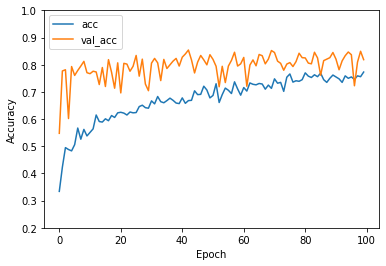

In [37]:
plt.plot(inc_history.history['acc'], label='acc')
plt.plot(inc_history.history['val_acc'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='upper left')

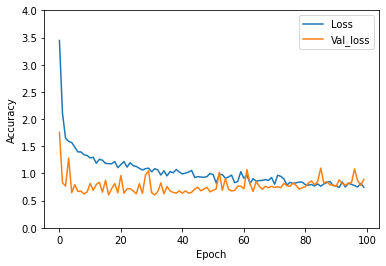

In [43]:

plt.plot(inc_history.history['loss'], label='Loss')
plt.plot(inc_history.history['val_loss'], label = 'Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 4])
plt.legend(loc='upper right')

In [44]:
test_labels = test_batches.classes

In [45]:
test_labels

array([0, 0, 0, ..., 6, 6, 6])

In [46]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [47]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

C:\Users\Annu\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1103/1103 [==============================] - 85s 72ms/step


In [48]:
predictions.shape

(1103, 7)

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [50]:
test_labels.shape

(1103,)

In [51]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [52]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 11   9   9   0   1   0   0]
 [  0  21   7   0   0   7   0]
 [  4  11  39   0   7  26   1]
 [  0   1   0   4   0   3   0]
 [  2   6  10   0  15  12   1]
 [  2  16  33   3  22 802   5]
 [  0   0   0   0   0   2  11]]


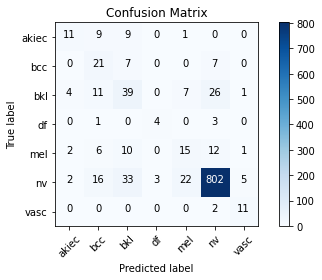

In [53]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [54]:

y_pred = np.argmax(predictions, axis=1)

y_true = test_batches.classes

In [55]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.58      0.37      0.45        30
         bcc       0.33      0.60      0.42        35
         bkl       0.40      0.44      0.42        88
          df       0.57      0.50      0.53         8
         mel       0.33      0.33      0.33        46
          nv       0.94      0.91      0.92       883
        vasc       0.61      0.85      0.71        13

    accuracy                           0.82      1103
   macro avg       0.54      0.57      0.54      1103
weighted avg       0.84      0.82      0.83      1103

